Accompanied with Stone et al. (2022), how to utilize the package to create temperature profile maps of AGN accretion disks using simulated spectroscopic/photometric light curve data.

First, we will need to import the necessary packages, as well as the package itself. All required packages are located in "requirements.txt"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numba_progress import ProgressBar
from numba import njit

import astropy.constants as const
import astropy.units as u
import awkward as ak
from scipy.sparse import csc_matrix

from tqdm import tqdm

In [2]:
import temp_map.utils as utils
import temp_map.algorithm as alg
import temp_map.plotting as tpplot
import temp_map.input as tpin
import temp_map.run as run

These are just parameters to make the plots look nice (to me at least)

In [3]:
import matplotlib as mpl

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams["figure.autolayout"] = False

mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams["axes.axisbelow"] = False

## Generating the input temperature profile map

We will be utilizing a given input temperature profile map to test the algorithm, and compare it to the output temperatue profile. 

First, we need to decide the parameters of the AGN that the map belongs to. This involves creating a dictionary of object-specific parameters ($M_{BH}$, distance $D$, redshift $z$, Eddington ratio $\lambda_{Edd}$, thin disk parameter $\alpha$, inclination $i$). Like in NK22, let's use NGC5548:

In [4]:
obj_dict = dict(obj_name='NGC5548',
            MBH=(10**7.505) * u.solMass.to(u.g),
            dist=75 * 1e6 * u.pc.to(u.cm),
            z=0.017,
            lambda_edd=0.1,
            alpha=6,
            inc=30*np.pi/180)

Now, we need to decide the sampling of the observations and the resolution of the temperature perturbation map $\delta T(u, t_p)$. 

- **$\lambda$ Resolution**:
Like stated in the paper, for the spectral range, we will sample the frequency evenly in logspace in the range $10^{14.5-15}$. SDSS spectra have $N_\nu \sim 5000$, so we'll stick to that.

- **$t_d$ Resolution**:
We will sample the light curves over 6 months with a daily cadence.

- **$t_p$ Resolution**:
As stated in the paper, the best resolution to use for these maps is $N_{t_p} = 100$.

- **$u$ Resolution**:
Like in NK22, we use $N_u = 50$.


In addition, all $\lambda$ and $t_d$ values will need to be redshift corrected, so that they'll be in the frame of the AGN.

In [6]:
td_vals = np.arange(0, 180, 5, dtype=float)
N_td = len(td_vals)

td_vals /= (1 + obj_dict['z'])



N_nu = 5000
nvals = np.linspace(14.5, 15, N_nu)
nu_vals = 10**nvals
lambda_vals = const.c.cgs.value / nu_vals

#Redshift correct
lambda_vals /= (1 + obj_dict['z'])
nu_vals = const.c.cgs.value / lambda_vals
nvals = np.log10(nu_vals)

We construct the $t_p$ array to start a few days before the first observation, and end a few days after the last observation.

In [7]:
N_tp = 100
tp_vals, dt = np.linspace(td_vals[0]-2, td_vals[-1]+2, N_tp, retstep=True)

To construct the $u$ array, we need to determine the range of radii probed by the spectroscopic data. This involves both the parameters of the AGN, and the range of $\lambda$ observed in the data. 

Luckily, there is a convenient function in "utils" to show us the range of relevant radii and output the range we need.

100%|██████████| 20/20 [00:00<00:00, 139.62it/s]


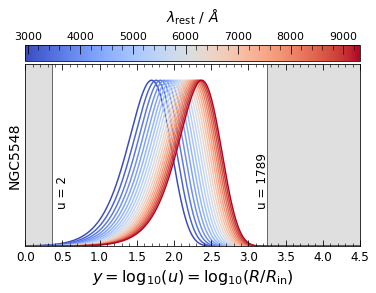

In [8]:
ymin, ymax, ymin2, ymax2 = utils.get_filter_kernels(lambda_vals, obj_dict, plot=True)

This shows the filter kernels (like in NK22) for each wavelength. Of course, this doesn't show the filter kernel for each wavelength, this would take much too long and make the plot much more confusing. Furthermore, the output values are in terms of $y = \log_{10}(u)$, which we'll be working in for the rest of the analysis.

We'll sample the radii evenly in $y$, between $y_{min}$ and $y_{max}$. 

In [9]:
Nu = 50
yvals, dy = np.linspace(ymin, ymax, Nu, retstep=True)

Now that we've determined the arrays for each parameter, we can finally construct the input temperature profile map. There are a few options for the type of map we want to use, the one we'll be using here is a typical lamppost-like outgoing wave moving at a fraction of the speed of light.

There's a function in the "input" module that will do this for us, and can output $\delta T / T$ (or 'dToT' for short). For this, we'll need to input the SMBH mass, the period of the wave, and it's velocity (as a fraction of $c$). We'll use half of the spanned time as the period and $0.5c$ as the velocity.

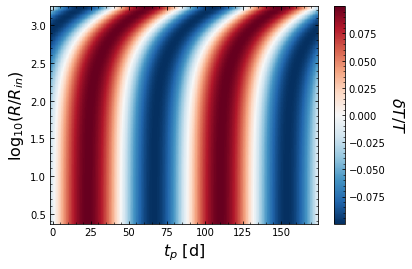

In [10]:
per = (tp_vals[-1] - tp_vals[0]) / 2
vel = 0.5
dToT_input = tpin.make_outgo(yvals, tp_vals, obj_dict['MBH'], per ,vel)




#Plot
plt.imshow(dToT_input, aspect='auto', origin='lower',
            extent=[tp_vals[0], tp_vals[-1], yvals[0], yvals[-1]], cmap='RdBu_r')

plt.ylabel(r'$\log_{10}(R / R_{in})$', fontsize=16)
plt.xlabel(r'$t_p$ [d]', fontsize=16)

cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\delta T / T$', rotation=270, labelpad=20, fontsize=16)

plt.show()

The function assumes that the amplitude of the wave is 0.1 for the entire map, though this can be changed if needed. It will be useful to have a flattened version of the temperature map later on 

In [11]:
dToT_input_flat = np.zeros(Nu*N_tp)
for i in range(N_tp):
    for j in range(Nu):
        dToT_input_flat[i*Nu + j] = dToT_input[j, i]

Now that we have the input temperature profile map, we can construct the input spectroscopic light curves. It is just as easy to produce photometric light curves, but we'll be sticking to spectra. 

We construct these light curves in a nonlinear fashion, using Eqn. 6 from NK22, but instead of using $T_0$, we use $T_0 + \delta T$. There is a function in "algorithm" that can help us with this.
There are multiple options in this function that serve for different scenarios. 

- **progress**: needs to be a "numba_progress" progress bar, as this is a numba function. 
- **include_F0**: tells the function if we want to include $F_{\lambda, 0} (\lambda)$. If not, the output will be divided by $F_{\lambda,0}$.
- **dat_type**: tells the function what kind of input temperature map we give it. We are using a $\delta T/ T$ temperature map, so we choose 'dToT'. We could also input a $\delta T$ temperature map, and use 'dT'
- **fluff_num**: deprecated, keep it set to 1

In [11]:
with ProgressBar(total=Nu*N_tp*N_nu*N_td) as progress:
    input_spec, _ = alg.make_F_dF_nonlinear(dToT_input, tp_vals, td_vals, lambda_vals, yvals, 
                                    obj_dict['MBH'], 
                                    obj_dict['lambda_edd'], 
                                    obj_dict['dist'], 
                                    obj_dict['inc'], 
                                    progress, 
                                    alpha=obj_dict['alpha'],
                                    include_F0=True, 
                                    dat_type='dToT')

  0%|          | 900000.0/4500000000 [00:06<9:27:50, 132051.93it/s]


This gives $F_\lambda$ spectra in a flattened array. It is flattened in such a way that the first $N_\nu$ values are the spectrum for the first $t_d$, the next $N_\nu$ are from the second $t_d$, etc.

Now, we need to add error to the input spectra to simulate actual spectra. To do this, we'll need to generate the steady-state spectrum $F_{\lambda,SS}$, and add error relative to it. The typical value we've used is $\sim 3\%$ of the steady-state.

The steady-state spectrum is generated using a similar function to the previous one:

In [12]:
with ProgressBar(total=Nu*N_tp*N_nu*N_td) as progress:
    F_ss, _ = alg.make_F_dF(dToT_input, tp_vals, td_vals, 
                                    lambda_vals, yvals, 
                                    obj_dict['MBH'], 
                                    obj_dict['lambda_edd'], 
                                    obj_dict['dist'], 
                                    obj_dict['inc'], 
                                    progress, 
                                    alpha=obj_dict['alpha'],
                                    dat_type='dToT', 
                                    include_F0=True) 

  0%|          | 900000.0/4500000000 [00:05<7:04:20, 176708.02it/s]


Now we generate the error for the input spectra. Instead of using a constant percentage across the whole spectrum, we'll draw from a normal distribution to determine the relative error for each data point. The mean relative error will be $3\%$ with a standard deviation of $0.5\%$.

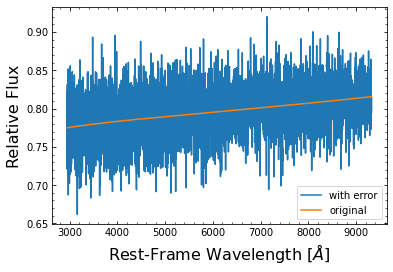

In [13]:
err_mean = 0.03
err_std = 0.005

input_err = np.random.normal( F_ss*err_mean, F_ss*err_std )
input_spec_w_err = np.random.normal(input_spec, input_err)



#Plot the spectrum with and without error for a random td (in this case the 60th)
a = 60
ind1 = a*N_nu
ind2 = (a+1)*N_nu

plt.plot(lambda_vals/1e-8, input_spec_w_err[ind1:ind2]/F_ss[ind1:ind2], label='with error')
plt.plot(lambda_vals/1e-8, input_spec[ind1:ind2]/F_ss[ind1:ind2], label='original')

plt.ylabel('Relative Flux', fontsize=16)
plt.xlabel('Rest-Frame Wavelength [$\AA$]', fontsize=16)
plt.legend()
plt.show()

Now, we have the input spectra with error, but in terms of the absolute flux $F_\lambda$. We need the input to be the flux perturbations $\delta F_\lambda$, so we'll need to subtract the mean spectrum to approximate it. So first, we'll need to generate the mean spectrum.

In [14]:
mean_spec = np.zeros(N_nu)
for i in range(N_td):
    mean_spec += input_spec_w_err[i*N_nu:(i+1)*N_nu]

mean_spec /= N_td

Now we can subtract the mean spectrum from the input spectra with error.

In [15]:
processed_input_spec = np.zeros(N_td*N_nu)
for i in range(N_td):
    processed_input_spec[i*N_nu:(i+1)*N_nu] = input_spec_w_err[i*N_nu:(i+1)*N_nu] - mean_spec

## Using the algorithm

Now that we have the input spectra and temperature map, we can start constructing the $W_\sigma$ matrix for the inversion. There is a function in "algorithm" that can construct this matrix for us, with a number of options (many similar to the function to construct $F_\lambda$).

The $W_\sigma$ matrix will lilely be very large ($N_\nu N_{t_d}$ x $N_u N_{t_p}$), so we will use a SciPy sparse CSC matrix to construct it. This requires an array for the column, row, and value of each nonzero element in the matrix.

However, there is a caveat: this is a numba function, which is very particular about what classes and functions can be used within it. For example, numba functions do not like python lists to be appended. So, we will need to use an Awkward array to construct the CSC sparse matrix arrays. These arrays are then used as inputs to the function, filled, and then output.

After we have these Awkward arrays, we need to turn them into arrays that can be accessed by other functions, so we get a "snapshot" of each of them. There is then a function (chunk_fill) to chunk-in the CSC matrix, which tracks how much of the matrix has been filled with a progress bar. It fills in the matrix in chunks of data, one chunk at a time (which is specified in one of the arguments).

This chunk filling function also requires the shape of the array, which would normally be $N_\nu N_{t_d}$ x $N_u N_{t_p}$. However, we include an additional parameter per wavelength to account for the difference in the model steady-state and the mean input spectrum. So, we use a shape of $N_\nu N_{t_d}$ x ($N_u N_{t_p} + N_\nu$).

In [16]:
row_dat = ak.ArrayBuilder()
col_dat = ak.ArrayBuilder()
input_dat = ak.ArrayBuilder()

with ProgressBar(total=Nu*N_tp*N_nu*N_td) as progress:
    rows, cols, inputs = alg.make_W_spec_w_mean(row_dat, col_dat, input_dat, 
                                                yvals, tp_vals, td_vals, 
                                                lambda_vals,
                                                obj_dict['lambda_edd'], 
                                                obj_dict['MBH'], 
                                                obj_dict['dist'], 
                                                obj_dict['inc'], 
                                                alpha=obj_dict['alpha'], 
                                                progress_hook=progress,
                                                errs=input_err, 
                                                dat_type='dToT')

row_snap = rows.snapshot()
col_snap = cols.snapshot()
dat_snap = inputs.snapshot()

W_matrix = utils.chunk_fill(row_snap, col_snap, dat_snap, shape=( N_nu*N_td, Nu*N_tp + N_nu ), Nchunk=int(1e6))

  4%|▎         | 164270000.0/4500000000 [00:25<11:20, 6370796.11it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [02:02<00:00,  1.35it/s]


Now that we have $W_\sigma$, we can construct the other relevant matrices for the inversion: $W_\sigma^T W_\sigma$, $I$, $D_k$, $D_l$.

It should be noted: we are working in terms of $\delta T / T$, **NOT** $\delta T$ (this was an option in the construction of the $W_\sigma$ matrix with "dat_type").

In NK22, they use $I_T$, $D_{kT}$, and $D_{lT}$, which are matrices divided by the steady-state temperature profile $T_0$. We include $T_0$ in the map we solve for, so we don't need to include it in all of these smoothing matrices and $W_\sigma$. This can be changed in the formation of $W_\sigma$.

There are functions to form the smoothing matrices, but only if we are working in terms of $\delta T / T$. This requires the size (of one side) of $W_\sigma^T W_\sigma$ and the size of the $u$ and $t_p$ arrays. To get these matrices when working in terms of $\delta T$, you would have to manually divide elements by the temperature as described in NK22.

In [17]:
WTW = W_matrix.transpose().dot( W_matrix )
size = WTW.shape[0]

I, Dk, Dl = alg.make_smoothing_matrices(Nu, N_tp, size)

We can now construct the right hand side of the equation: $W_\sigma^T \delta F_\sigma$

In [18]:
RHS = W_matrix.transpose() @ (processed_input_spec/input_err)
RHS = csc_matrix(RHS).transpose()

Next, we use the inversion formula specified in the paper:
$\delta T = [W_\sigma^T W_\sigma + \xi(I + D_k + D_l)] W_\sigma^T \delta F_\sigma$

To do this, we need to choose smoothing factors $\xi$ to use. I'll pick the usual values: 1, 10, 100, 1000.
I've also made a function that parallelizes the inversion with numba - this isn't needed but speeds up the process. Each smoothing factor will have an output temperature profile map, which I'll put into an array **inv_outputs**.

In [19]:
@njit(parallel=True)
def fast_res(A, b):
    return np.linalg.inv(A) @ b

xi_vals = [1,10,100,1000]

inv_outputs = []
for xi in tqdm(xi_vals):
    A = csc_matrix( WTW + xi*(I + Dk + Dl) )

    res = fast_res(A.todense(), RHS.todense())
    res = np.array(res).T[0]

    inv_outputs.append( res )

100%|██████████| 4/4 [00:21<00:00,  5.38s/it]


## Constructing and plotting the output

We have the output maps now, but they are in their flattened form, so we need to reshape them to be a 2D array like we had before. We'll place all of the reshaped arrays in an array labeled **dToT_outputs_reshape**.

In [20]:
dToT_outputs_reshape = []

for n in range(len(inv_outputs)):
    dToT_output_reshape = np.zeros((Nu, N_tp))
    for i in range(Nu*N_tp):
        dToT_output_reshape[ i%Nu, i//Nu ] = inv_outputs[n][i]
        
    dToT_outputs_reshape.append(dToT_output_reshape)

We can't plot the results yet because we need the $\chi^2$ values to display on the plot. To get these values, we'll need to construct the output spectra from the output temperature maps to compare to the input spectra. 

We can do this using the simple formula from the paper:
$\delta F_\sigma = W_\sigma \cdot \delta T$

We can also get the extra parameters used in the inversion as additive offsets between the model and data mean spectrum, one per wavelength. It should be noted that this gives us the output spectra **relative to the error** $\delta F_\sigma$, so we need to multiply by the error of the input spectra.

In [21]:
new_spec = []
for i in range(len(inv_outputs)):
    out = np.array( (W_matrix @ inv_outputs[i]) )
    new_spec.append( out * input_err )

offsets = []
for i in range(len(inv_outputs)):
    offsets.append( inv_outputs[i][Nu*N_tp:]  )

It's easier to manipulate the data (and plot it) if we reshape the input and output data (similar to the input temperature map).

In [22]:
new_spec_stacked = np.zeros( (len(xi_vals), N_nu, N_td) )
flux_dat_stacked = np.zeros( (N_nu, N_td) )
err_dat_stacked = np.zeros( (N_nu, N_td) )

for i in range(len(new_spec)):
    for j in range(N_td):
        ind1 = j*N_nu
        ind2 = (j+1)*N_nu

        new_spec_stacked[i,:,j] = new_spec[i][ind1:ind2]

for j in range(N_td):
    ind1 = j*N_nu
    ind2 = (j+1)*N_nu

    flux_dat_stacked[:,j] = processed_input_spec[ind1:ind2]
    err_dat_stacked[:,j] = input_err[ind1:ind2]

Next, we need to normalize the output light curves so they match the input light curves. Each light curve (i.e. wavelength) has an offset fitted by the algorithm, but still needs a multiplicative factor to normalize it to the input light curve. We can obtain this factor by minimizing $\chi^2$ and using the fitted offsets.


Let $\delta F_{in}(\lambda, t_d) = m(\xi, \lambda) \delta F_{out}(\xi, \lambda, t_d) + {\rm offsets} (\xi, \lambda)$

Minimizing $\chi^2$:  
$S_{xy} = \sum \frac{\delta F_{in}   \delta F_{out}}{\sigma^2}$  
$S_{x2} = \sum \frac{\delta F_{out} }{\sigma^2}$  
$S_x = \sum \frac{\delta F_{out}}{\sigma^2}$  
  
$m(\xi, \lambda) = \frac{S_{xy} - {\rm offsets}(\xi, \lambda) S_x }{S_{x2}}$


In [23]:
m_coefs = np.zeros( ( len(xi_vals), N_nu ) )

for i in range(len(xi_vals)):
    for j in range(N_nu):
        lc_in = flux_dat_stacked[j,:]
        lc_err = err_dat_stacked[j,:]
        lc_out = new_spec_stacked[i,j,:]

        sxy = np.sum(lc_out*lc_in / lc_err**2)
        sx2 = np.sum(lc_out**2 / lc_err**2)
        sx = np.sum(lc_out / lc_err**2)

        m_coefs[i,j] = (sxy - offsets[i][j]*sx)/sx2 

Now that we have the multiplicative factors $m(\xi, \lambda)$, we can normalize the output spectra, and get the $\chi^2$ per data point ($\chi^2_\nu$) for each temperature map.

In [24]:
fitted_spec = np.zeros( ( len(xi_vals), N_nu, N_td )  )

chi2_tot = []
for i in range(len(xi_vals)):
    chi2_tot.append([])

for a in tqdm( range(N_td) ):
    ind1 = a*N_nu
    ind2 = (a+1)*N_nu


    spec_in = processed_input_spec[ind1:ind2]
    spec_err = input_err[ind1:ind2]

    for i in range(len(xi_vals)):
        spec_out = m_coefs[i,:]* new_spec[i][ind1:ind2] + offsets[i]

        fitted_spec[i,:,a] = spec_out
        
        chi2 = np.sum( (spec_in - spec_out)**2 / spec_err**2  )/N_nu
        chi2_tot[i].append(chi2)

chi2_tot = np.mean(chi2_tot, axis=1)        

100%|██████████| 180/180 [00:00<00:00, 2859.92it/s]


Now that we have $\chi^2_\nu$, we can plot the output temperature maps. There is a function to output the temperature maps and the input temperature map. Each temperature map will have a scale it is divided by, which is by default the 99 $^{th}$ percentile of the absolute value of the map, but this number can be changed.

This function takes multiple optional arguments:
- **fname**: the name of the file to save the plot to. If **None**, the plot will not be saved.
- **show**: whether to show the plot. If **False**, the plot will not be shown and the figure will be an output of the function.
- **interpolation**: the interpolation method to use when plotting the temperature maps.
- **percent**: the percentile of the absolute value of the data in the map to use as the scale.
- **date_type**: can either be **rest** or **obs** depending on the frame of the time values used

4it [00:00, 252.11it/s]


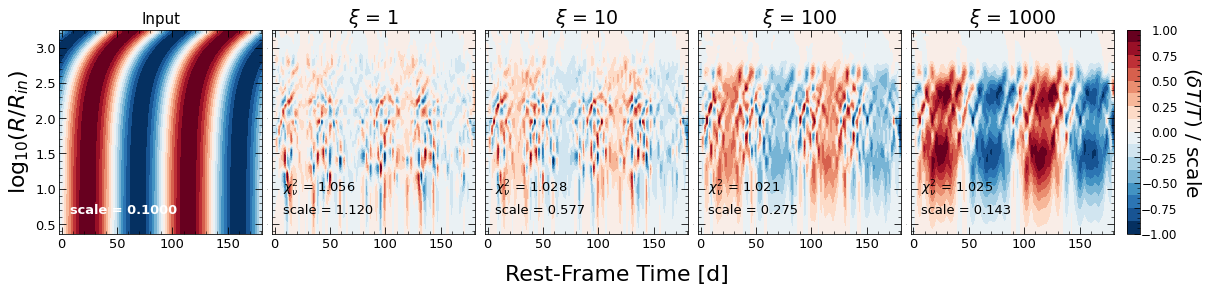

In [41]:
tpplot.plot_profs_inout(dToT_input, dToT_outputs_reshape, tp_vals, 
                              yvals, xi_vals, chi2_tot,
                              fname=None, show=True, cmap_num=16, interval=50,
                              interpolation='gaussian')

We can also plot the output spectra against the input spectra (for each $\xi$) for each time $t_d$ in an animation, and save the animation to a file.

MovieWriter ffmpeg unavailable; using Pillow instead.


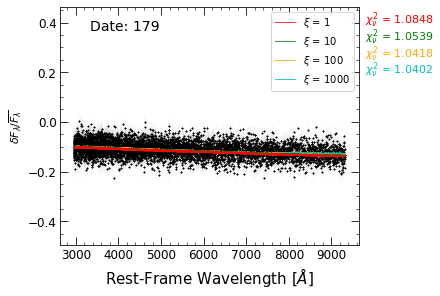

In [42]:
spec_fname = 'OutputSpectra.gif'
tpplot.animate_spectra_out(fitted_spec, flux_dat_stacked, err_dat_stacked, 
                           mean_spec, td_vals, lambda_vals, 
                           xi_vals, spec_fname, fps=10)

We can also save all data to a numpy file for later use. And that's all!

To make this as easy as possible, there is also a function in the module that will run the entire algorithm for you:

Making spectra...
  0%|          | 180000.0/900000000 [00:03<4:15:55, 58600.06it/s] 
Getting steady-state...
  0%|          | 180000.0/900000000 [00:01<2:25:29, 103081.22it/s]
Making W matrix...
  4%|▎         | 33390000.0/900000000 [00:07<03:20, 4330581.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Inverting...


100%|██████████| 4/4 [00:19<00:00,  4.99s/it]
5it [00:00, 250.88it/s]


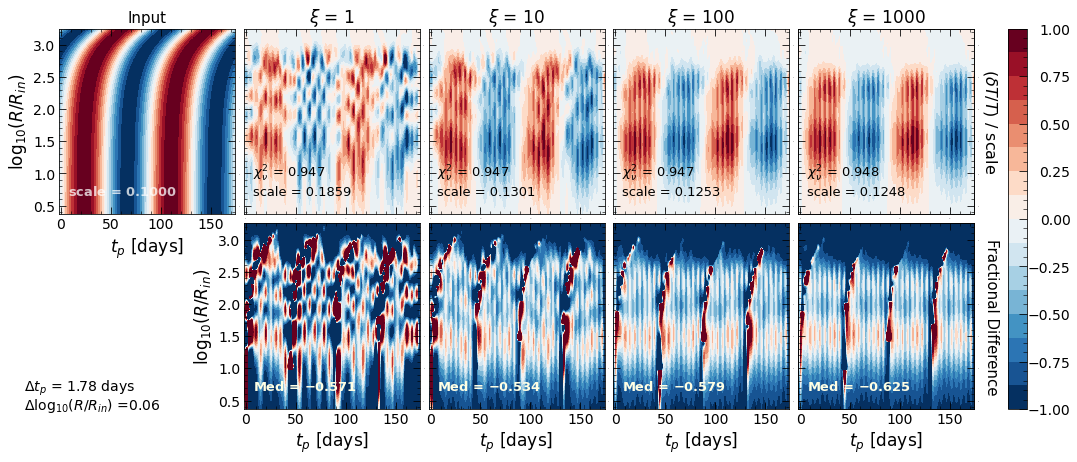

MovieWriter ffmpeg unavailable; using Pillow instead.


Animating spectra...


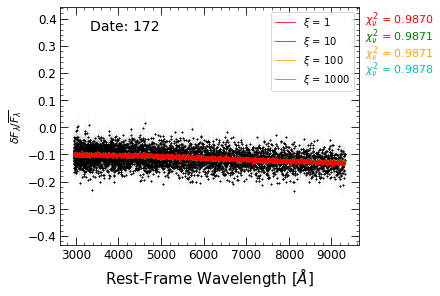

In [12]:
import importlib
importlib.reload(run)

output = run.run_spectra_sim(dToT_input, tp_vals, yvals, td_vals, lambda_vals, 
                            AGN_params=obj_dict, xi_vals=[1,10,100,1000], 
                            show_tp=True, tp_fname=None, spec_fname='OutputSpectra.gif', dat_fname=None) 